```{index} Gantt charts
```
```{index} disjunctive programming
```
```{index} single: application; job shop
```
```{index} single: application; scheduling
```
```{index} single: solver; highs
```
# Extra material: Job shop scheduling

In [ ]:
# install dependencies and select solver
%pip install -q amplpy matplotlib

SOLVER = "highs"

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Job Shop Scheduling

Job shop scheduling is one of the classic problems in Operations Research. 

A *job shop* refers to a collection of *machines* that process *jobs*. The jobs may be simple or complex, such as the production of a custom part, a print job at printing house, a patient treated in a hospital, or a meal produced in a fast food restaurant. The term "machines" can refer any device, person, or resource involved in the processing the jobs. In what follows in this notebook, a job comprises a series of tasks that requiring use of particular machines for known duration, and which must be completed in specified order. 

The *job shop scheduling problem* is to schedule a set of jobs on the available machines to optimize a metric of productivity. A typical metric is the *makespan* which refers to the time needed to process all jobs. 

At a basic level, the data required to specify a job shop scheduling problem consists of two tables. The first table is a decomposition of the jobs into a series of tasks, each task listing the job name, name of the required machine, and task duration. A second table list task pairs where the first task must be completed before the second task can be started.

Real applications of job shop scheduling often include additional considerations such as time that may be required to set up machines prior to the start of the next job, or limits on the time a job can wait between processing steps.  

## Job shop example

The following example of a job shop is from from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Dash Optimization, 2000.

In this example, there are three printed paper products that must pass through color printing presses in a particular order. The given data consists of a flow sheet showing the order in which each job passes through the color presses

![jobshopdiagram.jpg](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/jobshopdiagram.jpg?raw=1)

and a table of data showing, in minutes, the amount of time each job requires on each machine.

| Machine | Color | Paper 1 | Paper 2 | Paper 3 |
| :-----: | :---: | :-----: | :-----: | :-----: |
| 1       | Blue  | 45      | 20      | 12      |
| 2       | Green | -       | 10      | 17      |
| 3       | Yellow| 10      | 34      | 28      |

What is the minimum amount of time (i.e, what is the makespan) for this set of jobs?

## Task decomposition

The first step in the analysis is to decompose the process into a series of tasks. Each task c(job, machine) pair. Some tasks cannot start until a prerequisite task is completed.

| Task (Job,Machine) | Duration | Prerequisite Task |
| :----------------: | :------: | :---------------: |
| (Paper 1, Blue)    | 45       | -                 |
| (Paper 1, Yellow)  | 10       | (Paper 1,Blue)    |
| (Paper 2, Blue)    | 20       | (Paper 2, Green)  |
| (Paper 2, Green)   | 10       | -                 |
| (Paper 2, Yellow)  | 34       | (Paper 2, Blue)   |
| (Paper 3, Blue)    | 12       | (Paper 3, Yellow) |
| (Paper 3, Green)   | 17       | (Paper 3, Blue)   |
| (Paper 3, Yellow)  | 28       | -                 |

We convert this to a JSON style representation where tasks are denoted by (Job,Machine) tuples in Python. The task data is stored in a Python dictionary indexed by (Job,Machine) tuples. The task data consists of a dictionary with duration ('dur') and (Job,Machine) pair for any prerequisite task.

In [2]:
TASKS = {
    ("Paper_1", "Blue"): {"dur": 45, "prec": None},
    ("Paper_1", "Yellow"): {"dur": 10, "prec": ("Paper_1", "Blue")},
    ("Paper_2", "Blue"): {"dur": 20, "prec": ("Paper_2", "Green")},
    ("Paper_2", "Green"): {"dur": 10, "prec": None},
    ("Paper_2", "Yellow"): {"dur": 34, "prec": ("Paper_2", "Blue")},
    ("Paper_3", "Blue"): {"dur": 12, "prec": ("Paper_3", "Yellow")},
    ("Paper_3", "Green"): {"dur": 17, "prec": ("Paper_3", "Blue")},
    ("Paper_3", "Yellow"): {"dur": 28, "prec": None},
}

## Model formulation

Each task is indexed by an ordered pair $(j, m)$ where $j$ refers to a job, and $m$ refers to a machine. Associated with each task is data describing the time needed to perform the task, and a preceding task that must be completed before the index task can start.

| Parameter | Description |
| :-------- | :-----------|
| $\text{dur}_{j,m}$ | Duration of task $(j,m)$ | 
| $\text{prec}_{j,m}$ | A task $(k,n) = \text{prec}_{j,m}$ that must be completed before task $(j,m)$| 

The choice of decision variables for this problem are key to modeling. We introduce $makespan$ as the time needed to complete all tasks. $makespan$ is a candidate objective function. Variable $start_{j,m}$ denotes the time when task $(j,m)$ begins.  

| Decision Variables | Description |
| :-------- | :-----------|
| $\text{makespan}$  | Completion of all jobs | 
| $\text{start}_{j,m}$ | Start time for task $(j,m)$ |

The constraints include lower bounds on the start and an upper bound on the completion of each task $(j,m)$

$$
\begin{align}
\text{start}_{j,m} & \geq 0\\
\text{start}_{j,m}+\text{dur}_{j,m} & \leq \text{makespan}
\end{align}
$$

Any preceding tasks must be completed before task $(j,m)$ can start.

$$
\begin{align}
\text{start}_{k,n}+\text{dur}_{k,n}\leq\text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{prec}_{j,m}
\end{align}
$$

Finally, for every task performed on machine $m$, there can be no overlap among those tasks. This leads to a set of pair-wise disjunctive constraints for each machine.

$$
\begin{align}
\left[\text{start}_{j,m}+\text{dur}_{j,m} \leq \text{start}_{k,m}\right] \veebar \left[\text{start}_{k,m}+\text{dur}_{k,m} \leq \text{start}_{j,m}\right]
\end{align}
$$

avoids conflicts for use of the same machine. 

## AMPL implementation

The job shop scheduling problem is implemented below in AMPL. The implementation consists of a function jobshop_model(TASKS) that accepts a dictionary of tasks and returns an AMPL model. 

In [3]:
%%writefile jobshop_model.mod

set JOBS;
set MACHINES;
set TASKS within {JOBS, MACHINES};
set TASKORDER within {TASKS, TASKS};
set DISJUNCTIONS within {JOBS, JOBS, MACHINES};

param dur{TASKS};
param ub;

var makespan >= 0, <= ub;
var start{TASKS} >= 0, <= ub;

minimize minimize_makespan: makespan;

s.t. finish_tasks {(j,m) in TASKS}:
    start[j, m] + dur[j, m] <= makespan;

s.t. preceding {(j, m, k, n) in TASKORDER}:
    start[k, n] + dur[k, n] <= start[j, m];

s.t. no_overlap {(j, k, m) in DISJUNCTIONS}:
    (start[j, m] + dur[j, m] <= start[k, m]
    or
    start[k, m] + dur[k, m] <= start[j, m])
    and not
    (start[j, m] + dur[j, m] <= start[k, m]
    and
    start[k, m] + dur[k, m] <= start[j, m]);

Overwriting jobshop_model.mod


In [4]:
def jobshop_model(TASKS):
    m = AMPL()
    m.read("jobshop_model.mod")

    jobs = list(set([j for (j, m) in TASKS]))
    machines = list(set([m for (j, m) in TASKS]))
    tasks = list(TASKS.keys())
    taskorder = [
        (j, m, k, n)
        for (j, m) in tasks
        for (k, n) in tasks
        if (k, n) == TASKS[(j, m)]["prec"]
    ]
    disjunctions = [
        (j, k, m) for (j, m) in tasks for (k, n) in tasks if m == n and j < k
    ]
    dur = {(j, m): TASKS[(j, m)]["dur"] for (j, m) in TASKS}
    ub = sum(dur[i] for i in dur)

    m.set["JOBS"] = jobs
    m.set["MACHINES"] = machines
    m.set["TASKS"] = tasks
    m.set["TASKORDER"] = taskorder
    m.set["DISJUNCTIONS"] = disjunctions

    m.param["dur"] = dur
    m.param["ub"] = ub

    return m


jobshop_model(TASKS)

In [5]:
def jobshop_solve(model):
    model.option["solver"] = SOLVER
    model.solve()

    start = model.var["start"].to_dict()
    dur = model.param["dur"].to_dict()
    tasks = model.set["TASKS"].to_dict()

    results = [
        {
            "Job": j,
            "Machine": m,
            "Start": start[j, m],
            "Duration": dur[j, m],
            "Finish": start[j, m] + dur[j, m],
        }
        for j, m in tasks
    ]
    return results


def jobshop(TASKS):
    return jobshop_solve(jobshop_model(TASKS))


results = jobshop(TASKS)
results

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 97
32 simplex iterations
0 branching nodes


[{'Job': 'Paper_1',
  'Machine': 'Blue',
  'Start': 41.99999999999993,
  'Duration': 45.0,
  'Finish': 86.99999999999993},
 {'Job': 'Paper_1',
  'Machine': 'Yellow',
  'Start': 86.99999999999993,
  'Duration': 10.0,
  'Finish': 96.99999999999993},
 {'Job': 'Paper_2',
  'Machine': 'Blue',
  'Start': 9.999999999999972,
  'Duration': 20.0,
  'Finish': 29.99999999999997},
 {'Job': 'Paper_2',
  'Machine': 'Green',
  'Start': 0.0,
  'Duration': 10.0,
  'Finish': 10.0},
 {'Job': 'Paper_2',
  'Machine': 'Yellow',
  'Start': 29.99999999999997,
  'Duration': 34.0,
  'Finish': 63.99999999999997},
 {'Job': 'Paper_3',
  'Machine': 'Blue',
  'Start': 29.99999999999997,
  'Duration': 12.0,
  'Finish': 41.99999999999997},
 {'Job': 'Paper_3',
  'Machine': 'Green',
  'Start': 79.99999999999997,
  'Duration': 17.0,
  'Finish': 96.99999999999997},
 {'Job': 'Paper_3',
  'Machine': 'Yellow',
  'Start': 1.999999999999972,
  'Duration': 28.0,
  'Finish': 29.99999999999997}]

## Printing schedules

In [6]:
import pandas as pd

schedule = pd.DataFrame(results)

print("\nSchedule by Job")
print(schedule.sort_values(by=["Job", "Start"]).set_index(["Job", "Machine"]))

print("\nSchedule by Machine")
print(schedule.sort_values(by=["Machine", "Start"]).set_index(["Machine", "Job"]))


Schedule by Job
                 Start  Duration  Finish
Job     Machine                         
Paper_1 Blue      42.0      45.0    87.0
        Yellow    87.0      10.0    97.0
Paper_2 Green      0.0      10.0    10.0
        Blue      10.0      20.0    30.0
        Yellow    30.0      34.0    64.0
Paper_3 Yellow     2.0      28.0    30.0
        Blue      30.0      12.0    42.0
        Green     80.0      17.0    97.0

Schedule by Machine
                 Start  Duration  Finish
Machine Job                             
Blue    Paper_2   10.0      20.0    30.0
        Paper_3   30.0      12.0    42.0
        Paper_1   42.0      45.0    87.0
Green   Paper_2    0.0      10.0    10.0
        Paper_3   80.0      17.0    97.0
Yellow  Paper_3    2.0      28.0    30.0
        Paper_2   30.0      34.0    64.0
        Paper_1   87.0      10.0    97.0


## Visualizing Results with Gantt Charts


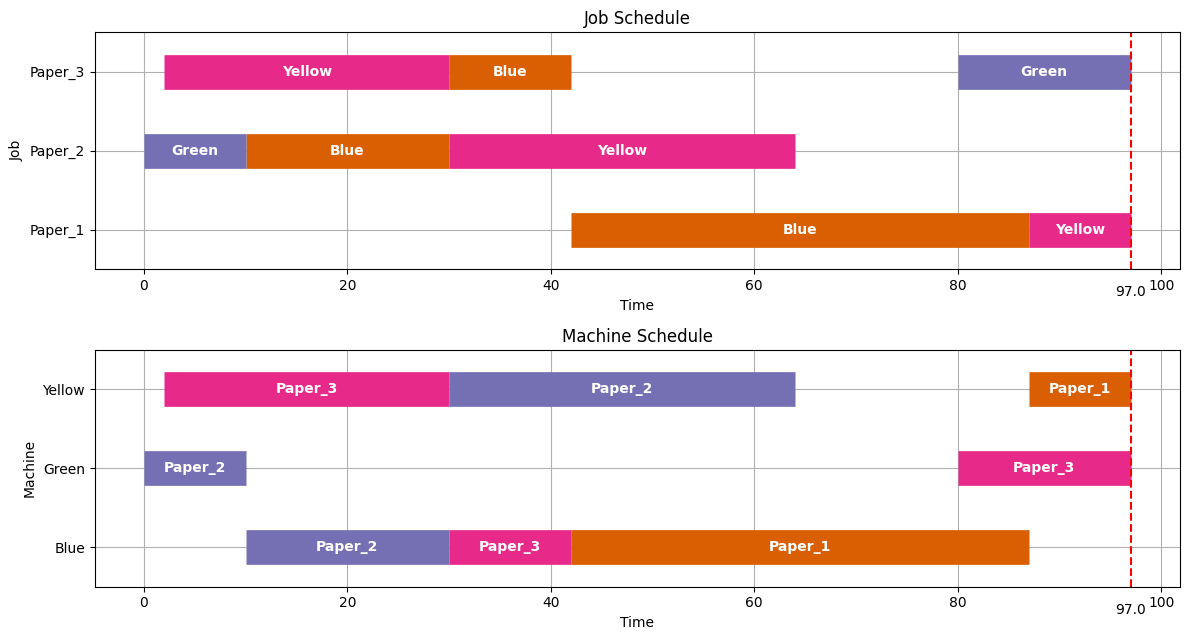

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl


def visualize(results):
    schedule = pd.DataFrame(results)
    JOBS = sorted(list(schedule["Job"].unique()))
    MACHINES = sorted(list(schedule["Machine"].unique()))
    makespan = schedule["Finish"].max()

    bar_style = {"alpha": 1.0, "lw": 25, "solid_capstyle": "butt"}
    text_style = {"color": "white", "weight": "bold", "ha": "center", "va": "center"}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=["Job", "Start"])
    schedule.set_index(["Job", "Machine"], inplace=True)

    fig, ax = plt.subplots(2, 1, figsize=(12, 5 + (len(JOBS) + len(MACHINES)) / 4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j, m) in schedule.index:
                xs = schedule.loc[(j, m), "Start"]
                xf = schedule.loc[(j, m), "Finish"]
                ax[0].plot([xs, xf], [jdx] * 2, c=colors[mdx % 7], **bar_style)
                ax[0].text((xs + xf) / 2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx] * 2, c=colors[jdx % 7], **bar_style)
                ax[1].text((xs + xf) / 2, mdx, j, **text_style)

    ax[0].set_title("Job Schedule")
    ax[0].set_ylabel("Job")
    ax[1].set_title("Machine Schedule")
    ax[1].set_ylabel("Machine")

    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(
            makespan,
            ax[idx].get_ylim()[0] - 0.2,
            "{0:0.1f}".format(makespan),
            ha="center",
            va="top",
        )
        ax[idx].plot([makespan] * 2, ax[idx].get_ylim(), "r--")
        ax[idx].set_xlabel("Time")
        ax[idx].grid(True)

    fig.tight_layout()


visualize(results)

## Application to the scheduling of batch processes

We will now turn our attention to the application of the job shop scheduling problem to the short term scheduling of batch processes. We illustrate these techniques using Example II from Dunn (2013).

![flowshop-Dunn-2013.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/flowshop-Dunn-2013.png?raw=1)

| Recipe  | Mixer | Reactor | Separator | Packaging |
| :-----: | :---: | :-----: | :-------: | :-------: |
| A       | 1.0   | 5.0     | 4.0       | 1.5       |
| B       | -     | -       | 4.5       | 1.0       |
| C       | -     | 3.0     | 5.0       | 1.5       |

### Single product strategies

Before going further, we create a function to streamline the generation of the TASKS dictionary.

Solution determined by presolve;
objective minimize_makespan = 11.5.


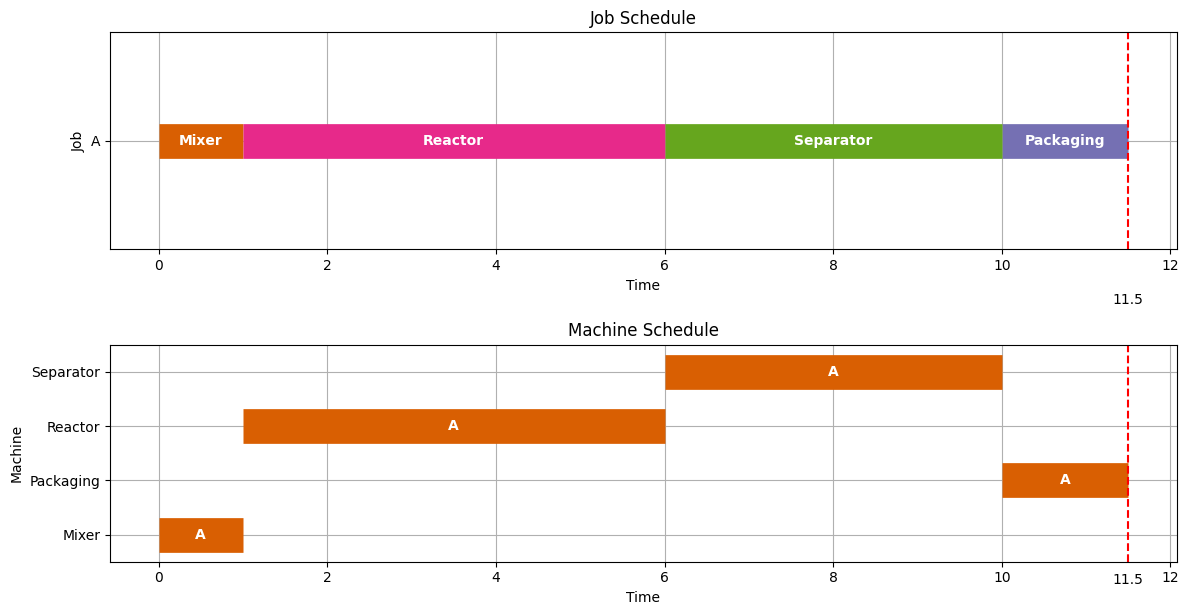

In [8]:
def recipe_to_tasks(jobs, machines, durations):
    TASKS = {}
    for j in jobs:
        prec = (None, None)
        for m, d in zip(machines, durations):
            task = (j, m)
            if prec == (None, None):
                TASKS.update({(j, m): {"dur": d, "prec": None}})
            else:
                TASKS.update({(j, m): {"dur": d, "prec": prec}})
            prec = task
    return TASKS


recipeA = recipe_to_tasks(
    "A", ["Mixer", "Reactor", "Separator", "Packaging"], [1, 5, 4, 1.5]
)
visualize(jobshop(recipeA))

Solution determined by presolve;
objective minimize_makespan = 5.5.


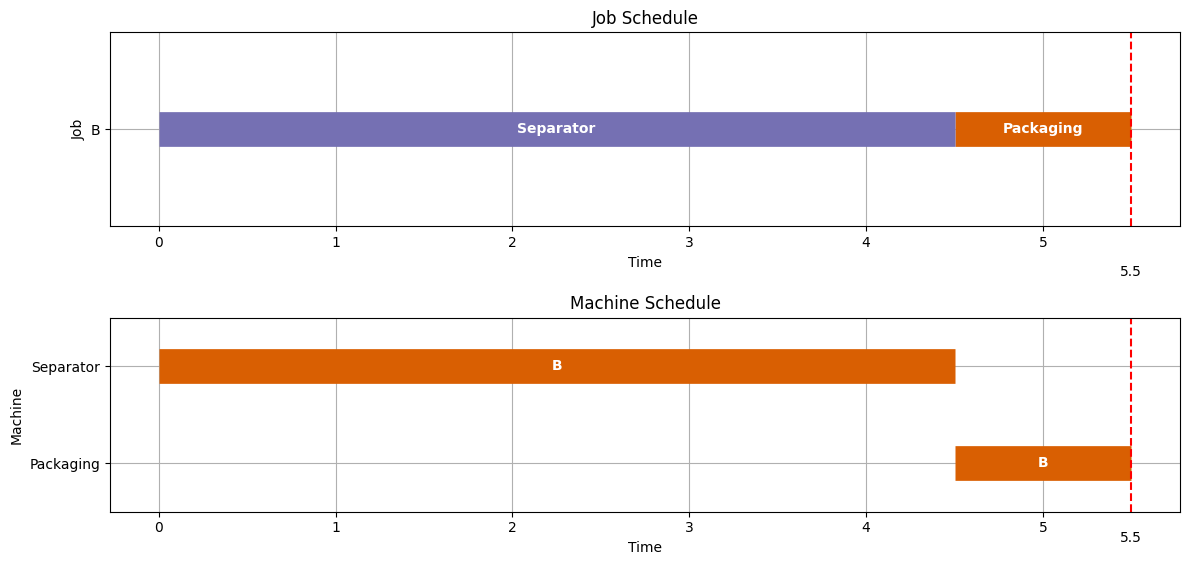

In [9]:
recipeB = recipe_to_tasks("B", ["Separator", "Packaging"], [4.5, 1])
visualize(jobshop(recipeB))

Solution determined by presolve;
objective minimize_makespan = 9.5.


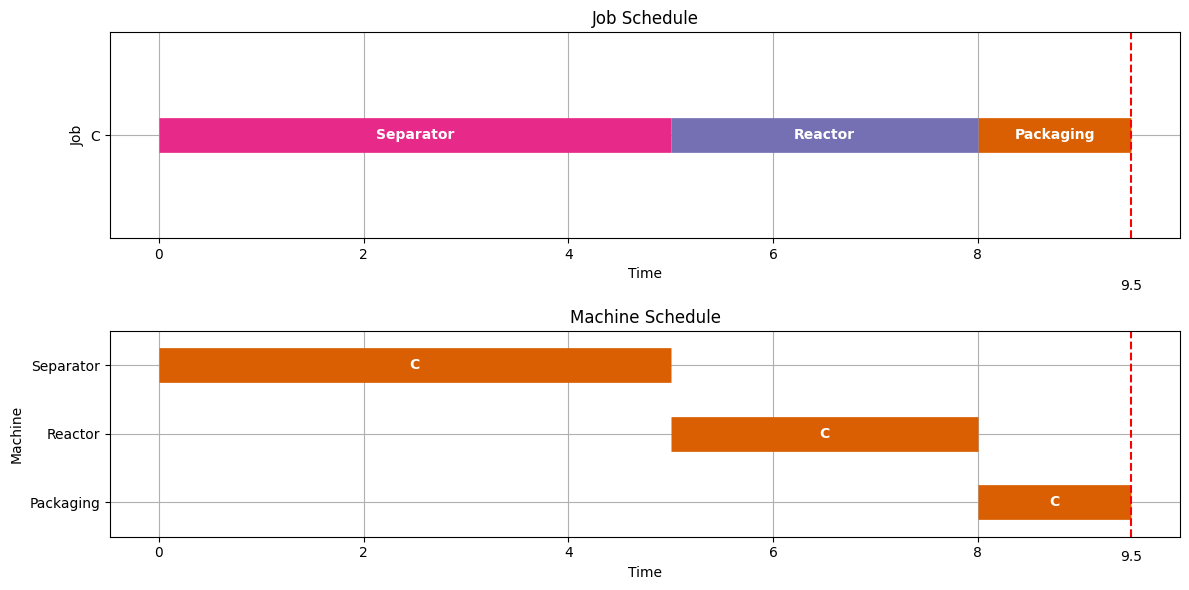

In [10]:
recipeC = recipe_to_tasks("C", ["Separator", "Reactor", "Packaging"], [5, 3, 1.5])
visualize(jobshop(recipeC))

### Multiple Overlapping tasks

Let's now consider an optimal scheduling problem where we are wish to make two batches of Product A.

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 26.5
3411 simplex iterations
79 branching nodes
absmipgap=1e-06, relmipgap=3.77358e-08
Makespan = 26.5


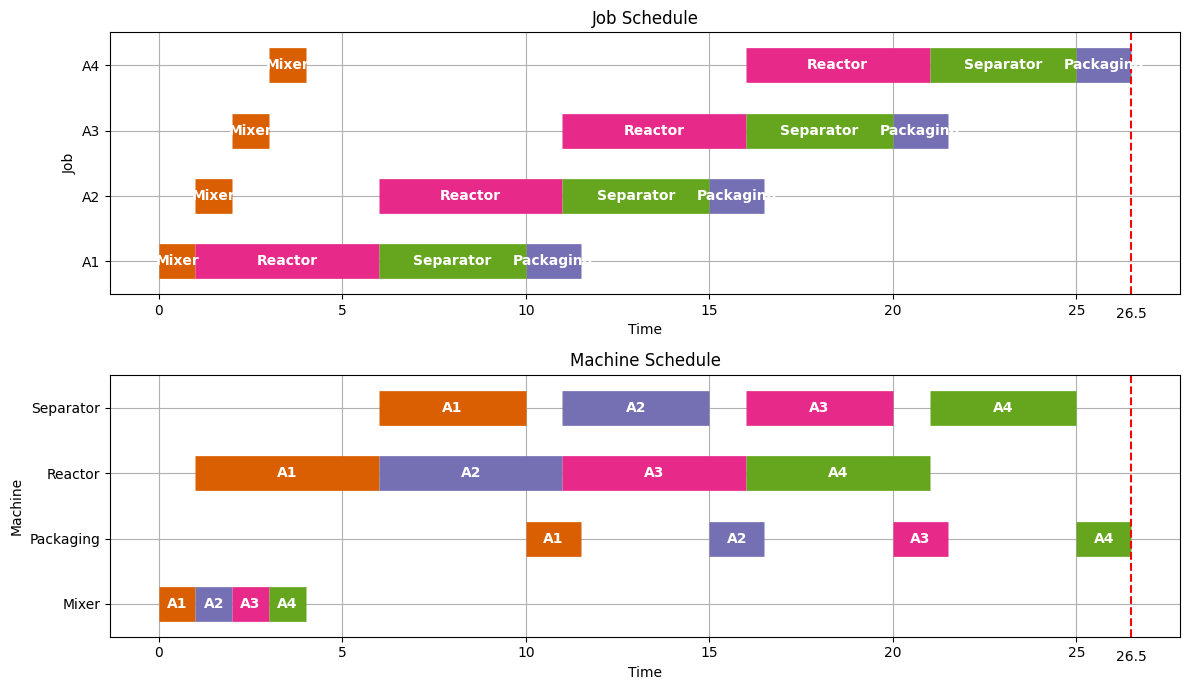

In [11]:
TASKS = recipe_to_tasks(
    ["A1", "A2", "A3", "A4"],
    ["Mixer", "Reactor", "Separator", "Packaging"],
    [1, 5, 4, 1.5],
)
results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task["Finish"] for task in results]))

Earlier we found that it took 11.5 hours to produce one batch of product A.  As we see here, we can produce a second batch with only 5.0 additional hours because some of the tasks overlap.  The overlapping of tasks is the key to gaining efficiency in batch processing facilities.

Let's next consider production of a single batch each of products A, B, and C.

('A', 'Mixer') {'dur': 1, 'prec': None}
('A', 'Reactor') {'dur': 5, 'prec': ('A', 'Mixer')}
('A', 'Separator') {'dur': 4, 'prec': ('A', 'Reactor')}
('A', 'Packaging') {'dur': 1.5, 'prec': ('A', 'Separator')}
('B', 'Separator') {'dur': 4.5, 'prec': None}
('B', 'Packaging') {'dur': 1, 'prec': ('B', 'Separator')}
('C', 'Separator') {'dur': 5, 'prec': None}
('C', 'Reactor') {'dur': 3, 'prec': ('C', 'Separator')}
('C', 'Packaging') {'dur': 1.5, 'prec': ('C', 'Reactor')}
HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 15
71 simplex iterations
1 branching nodes
Makespan = 15.0


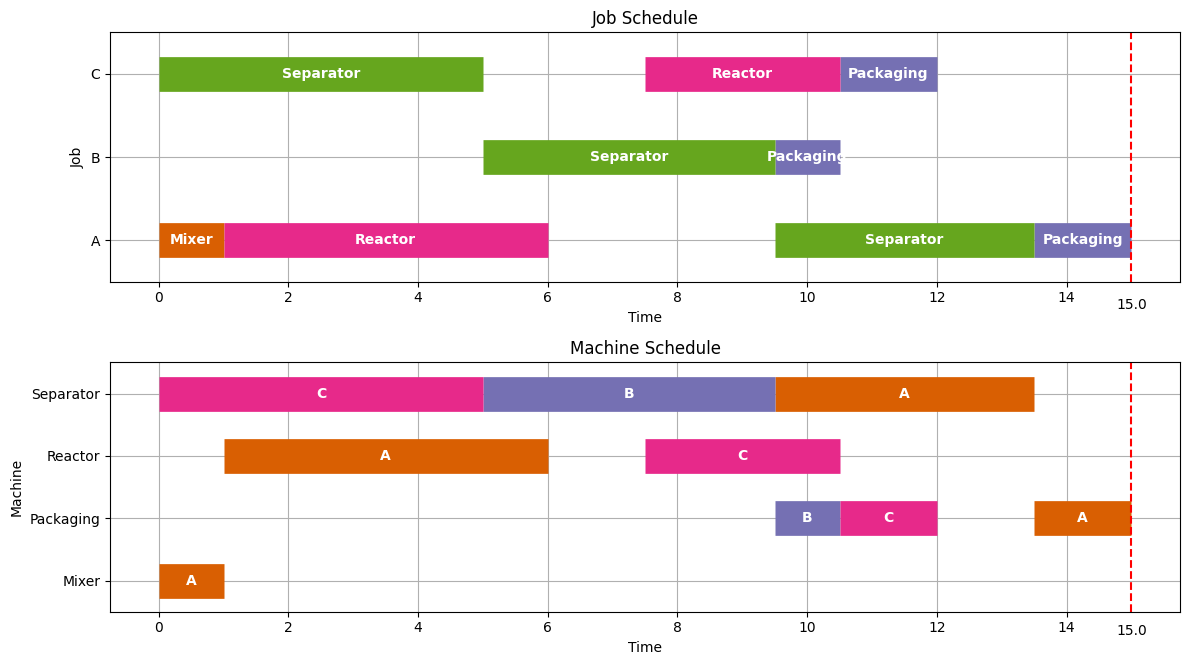

In [12]:
# update is used to append dictionaries
TASKS = recipeA
TASKS.update(recipeB)
TASKS.update(recipeC)

for k, v in TASKS.items():
    print(k, v)

results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task["Finish"] for task in results]))

The individual production of A, B, and C required 11.5, 5.5, and 9.5 hours, respectively, for a total of 25.5 hours. As we see here, by scheduling the production simultaneously, we can get all three batches done in just 15 hours. 

As we see below, each additional set of three products takes an additional 13 hours.  So there is considerable efficiency gained by scheduling over longer intervals whenever possible.

HiGHS 1.5.1:HiGHS 1.5.1: optimal solution; objective 28
12290 simplex iterations
622 branching nodes
Makespan = 27.99999999999888


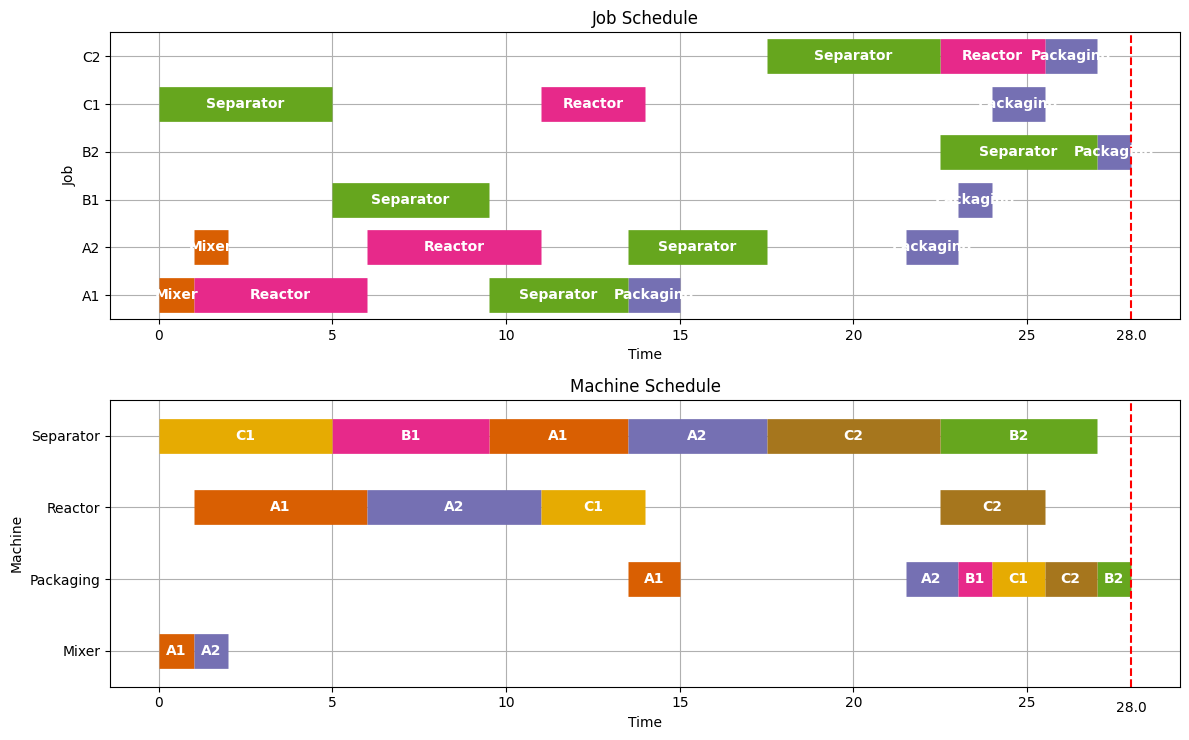

In [13]:
TASKS = recipe_to_tasks(
    ["A1", "A2"], ["Mixer", "Reactor", "Separator", "Packaging"], [1, 5, 4, 1.5]
)
TASKS.update(recipe_to_tasks(["B1", "B2"], ["Separator", "Packaging"], [4.5, 1]))
TASKS.update(
    recipe_to_tasks(["C1", "C2"], ["Separator", "Reactor", "Packaging"], [5, 3, 1.5])
)

results = jobshop(TASKS)
visualize(results)
print("Makespan =", max([task["Finish"] for task in results]))

### Adding time for unit clean out

A common feature of batch unit operations is a requirement that equipment be cleaned prior to reuse. 

In most cases the time needed for clean out would be specific to the equipment and product. But for the purposes this notebook, we implement can implement a simple clean out policy with a single non-negative parameter $t_{clean} \geq 0$ which, if specified, requires a period no less than $t_{clean}$ between the finish of one task and the start of another on every piece of equipment.

This policy is implemented by modifying the usual disjunctive constraints to avoid machine conflicts to read

$$
\begin{align}
\left[\text{start}_{j,m}+\text{dur}_{j,m} + t_{clean} \leq \text{start}_{k,m}\right] \vee \left[\text{start}_{k,m}+\text{dur}_{k,m} + t_{clean} \leq \text{start}_{j,m}\right]
\end{align}
$$

For this purpose, we write a new JobShopModel_Clean

In [14]:
%%writefile jobshop_model_clean.mod

set JOBS;
set MACHINES;
set TASKS within {JOBS, MACHINES};
set TASKORDER within {TASKS, TASKS};
set DISJUNCTIONS within {JOBS, JOBS, MACHINES};

param dur{TASKS};
param ub;

var makespan >= 0, <= ub;
var start{TASKS} >= 0, <= ub;

minimize minimize_makespan: makespan;

s.t. finish_tasks {(j,m) in TASKS}:
    start[j, m] + dur[j, m] <= makespan;

s.t. preceding {(j, m, k, n) in TASKORDER}:
    start[k, n] + dur[k, n] <= start[j, m];

s.t. no_overlap {(j, k, m) in DISJUNCTIONS}:
    (start[j, m] + dur[j, m] + tclean <= start[k, m]
    or
    start[k, m] + dur[k, m] + tclean <= start[j, m]);

Overwriting jobshop_model_clean.mod


HiGHS 1.5.1:HiGHS 1.5.1: optimal solution; objective 28
12290 simplex iterations
622 branching nodes
Makespan = 27.99999999999888


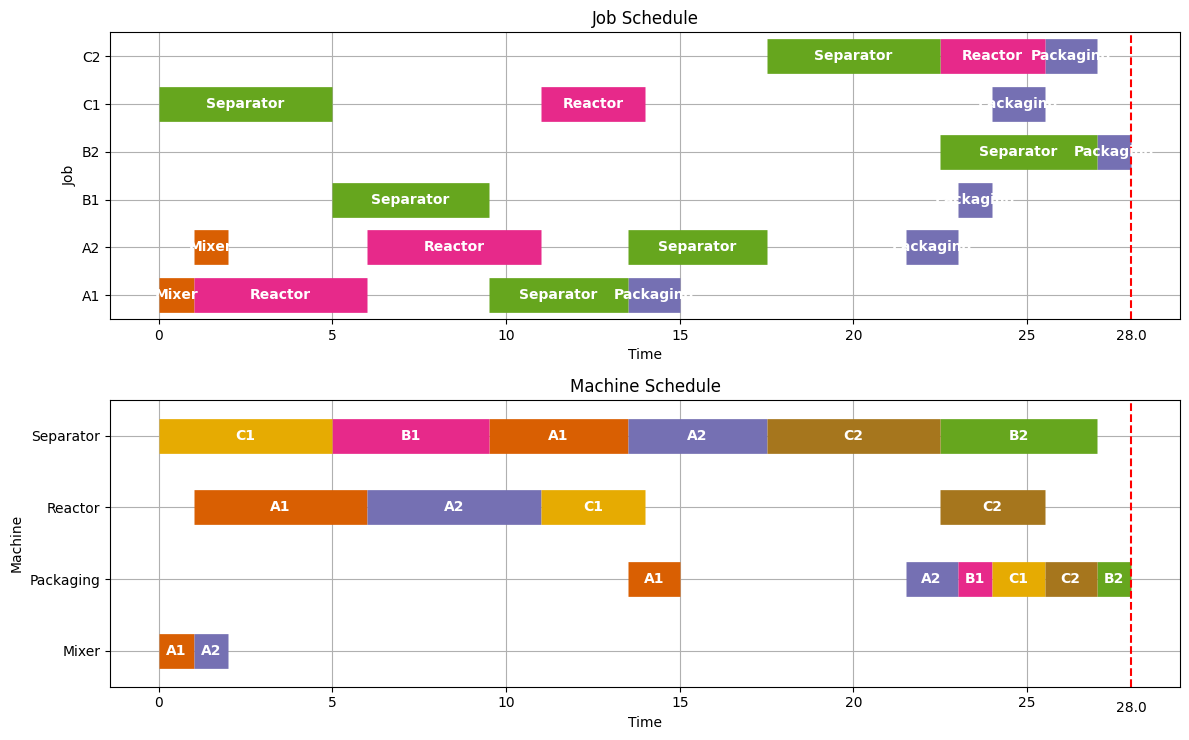

In [15]:
def jobshop_model_clean(TASKS, tclean=0):
    m = AMPL()
    m.read("jobshop_model.mod")

    jobs = list(set([j for (j, m) in TASKS]))
    machines = list(set([m for (j, m) in TASKS]))
    tasks = list(TASKS.keys())
    taskorder = [
        (j, m, k, n)
        for (j, m) in tasks
        for (k, n) in tasks
        if (k, n) == TASKS[(j, m)]["prec"]
    ]
    disjunctions = [
        (j, k, m) for (j, m) in tasks for (k, n) in tasks if m == n and j < k
    ]
    dur = {(j, m): TASKS[(j, m)]["dur"] for (j, m) in TASKS}
    ub = sum(dur[i] for i in dur)

    m.set["JOBS"] = jobs
    m.set["MACHINES"] = machines
    m.set["TASKS"] = tasks
    m.set["TASKORDER"] = taskorder
    m.set["DISJUNCTIONS"] = disjunctions

    m.param["dur"] = dur
    m.param["ub"] = ub

    return m


model = jobshop_model_clean(TASKS, tclean=0.5)
results = jobshop_solve(model)
visualize(results)
print("Makespan =", max([task["Finish"] for task in results]))

### Adding a zero wait policy

One of the issues in the use of job shop scheduling for chemical process operations are situations where there it is not possible to store intermediate materials. If there is no way to store intermediates, either in the processing equipment or in external vessels, then a **zero-wait** policy may be required. 

A zero-wait policy requires subsequent processing machines to be available immediately upon completion of any task. To implement this policy, the usual precident sequencing constraint of a job shop scheduling problem, i.e.,

$$
\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} \leq \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}
\end{align*}
$$

is changed to 

$$
\begin{align*}
\text{start}_{k,n}+\text{Dur}_{k,n} = \text{start}_{j,m}\ \ \ \ \text{for } (k,n) =\text{Prec}_{j,m}\text{ and ZW is True}
\end{align*}
$$

if the zero-wait policy is in effect. 

While this could be implemented on an equipment or product specific basis, here we add an optional ZW flag to the JobShop function that, by default, is set to False.

In [16]:
%%writefile jobshop_model_clean_zw.mod

set JOBS;
set MACHINES;
set TASKS within {JOBS, MACHINES};
set TASKORDER within {TASKS, TASKS};
set DISJUNCTIONS within {JOBS, JOBS, MACHINES};

param dur{TASKS};
param ub;
param tclean;
param ZW default 1;

var makespan >= 0, <= ub;
var start{TASKS} >= 0, <= ub;

minimize minimize_makespan: makespan;

s.t. finish_tasks {(j,m) in TASKS}:
    start[j, m] + dur[j, m] <= makespan;

s.t. preceding {(j, m, k, n) in TASKORDER}:
    ZW == 1 ==> start[k, n] + dur[k, n] == start[j, m]
    else
        start[k, n] + dur[k, n] <= start[j, m];
    
s.t. disjunctions {(j, k, m) in DISJUNCTIONS}:
    (start[j, m] + dur[j, m] + tclean <= start[k, m]
    or
    start[k, m] + dur[k, m] + tclean <= start[j, m]);

Overwriting jobshop_model_clean_zw.mod


HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 32
1552 simplex iterations
81 branching nodes
Makespan = 32.0


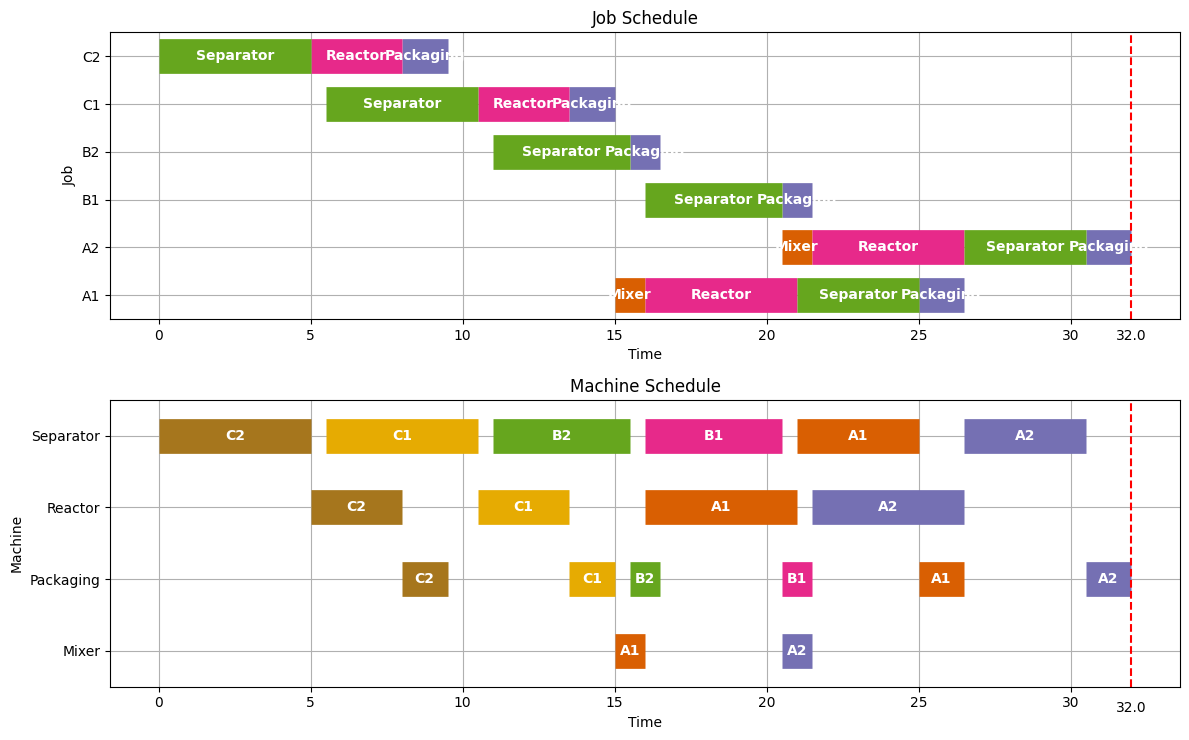

In [17]:
def jobshop_model_clean_zw(TASKS, tclean=0, ZW=False):
    m = AMPL()
    m.read("jobshop_model_clean_zw.mod")

    jobs = list(set([j for (j, m) in TASKS]))
    machines = list(set([m for (j, m) in TASKS]))
    tasks = list(TASKS.keys())
    taskorder = [
        (j, m, k, n)
        for (j, m) in tasks
        for (k, n) in tasks
        if (k, n) == TASKS[(j, m)]["prec"]
    ]
    disjunctions = [
        (j, k, m) for (j, m) in tasks for (k, n) in tasks if m == n and j < k
    ]
    dur = {(j, m): TASKS[(j, m)]["dur"] for (j, m) in TASKS}
    ub = sum(dur[i] for i in dur)

    m.set["JOBS"] = jobs
    m.set["MACHINES"] = machines
    m.set["TASKS"] = tasks
    m.set["TASKORDER"] = taskorder
    m.set["DISJUNCTIONS"] = disjunctions

    m.param["dur"] = dur
    m.param["ub"] = ub
    m.param["tclean"] = tclean
    m.param["ZW"] = 1 if ZW else 0

    m.option["solver"] = SOLVER

    return m


model = jobshop_model_clean_zw(TASKS, tclean=0.5, ZW=True)
results = jobshop_solve(model)
visualize(results)
print("Makespan =", max([task["Finish"] for task in results]))

## References

* Applegate, David, and William Cook. ["A computational study of the job-shop scheduling problem."](https://doi.org/10.1287/ijoc.3.2.149) ORSA Journal on computing 3, no. 2 (1991): 149-156. [pdf available](http://www.math.uwaterloo.ca/~bico/papers/jobshop.pdf)
* Beasley, John E. ["OR-Library: distributing test problems by electronic mail."](https://www.jstor.org/stable/pdf/2582903.pdf?casa_token=RWUXQ6e2VngAAAAA:g-dwMXjJfCUWqoLJk5y-MpDDhLmJKSGE36YU5kpkXZ71dmos25vntN0RlDFLxDme_QsOw8Oc3oi6juXCkVCfm2gcycCK0SYNoOnOZqRYDp3EqSrXP6nDeQ) Journal of the operational research society 41, no. 11 (1990): 1069-1072. [OR-Library](http://people.brunel.ac.uk/~mastjjb/jeb/info.html)
* Guéret, Christelle, Christian Prins, and Marc Sevaux. ["Applications of optimization with Xpress-MP."](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.69.9634&rep=rep1&type=pdf) contract (1999): 00034.
* Manne, Alan S. ["On the job-shop scheduling problem."](https://doi.org/10.1287/opre.8.2.219) Operations Research 8, no. 2 (1960): 219-223.

## Exercises

### Task specific cleanout

Clean out operations are often slow and time consuming. Further more, the time required to perform a clean out frequently depends on the type of machine, and the task performed by the machine. For this exercise, create a data format to include task-specific clean out times, and model the job shop model to accommodate this additional information.

### Computational impact of a zero-wait policy

Repeat the benchmark problem calculation, but with a zero-wait policy. Does the execution time increase or descrease as a consequence of specifying zero-wait?